In [1]:
import warnings;
warnings.filterwarnings('ignore');

In [2]:
import pandas as pd
import os
import pymc3 as pm
import arviz as az
from theano import tensor as T
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle
from my_utils import modeler
import importlib
importlib.reload(modeler)
import matplotlib.pyplot as plt

In [3]:
AGGREGATED_PATH = "output/aggregated_features/"

## __Free viewing__

### __General empathy__

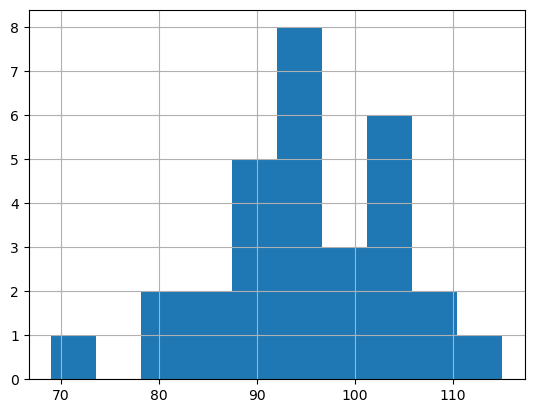

In [4]:
quest_before = pd.read_csv("datasets/EyeT/Questionnaire_datasetIA.csv")
quest_before.index.name = "Participant"
free_viewing_empathy = quest_before[quest_before.index%2 == 0]["Total Score original"]
free_viewing_empathy.hist();

#### __Fixations__

In [5]:
free_fix_features_train, free_fix_labels_train, free_sac_features_train, free_sac_labels_train =  modeler.get_features(AGGREGATED_PATH, "train", "free")

<BarContainer object of 20 artists>

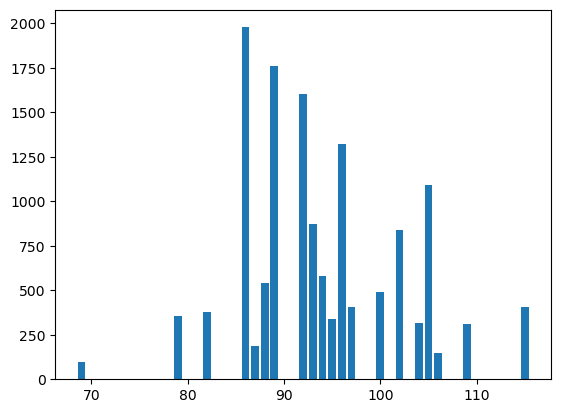

In [8]:
from collections import Counter
empathy_frequencies = dict(Counter(free_fix_labels_train))
plt.bar([k for k in empathy_frequencies.keys()], [v for v in empathy_frequencies.values()])
#   plt.hist([k for k in empathy_frequencies.keys()])

In [27]:
n_components = 2

with pm.Model() as free_fix_empathy:
    X = pm.Data("x", free_fix_features_train)
    Y = pm.Data("y", free_fix_labels_train)

    π = pm.Dirichlet("π", np.ones(n_components))
    α1 = pm.Normal('α1', mu=85, sd=20) 
    β1 = pm.Normal("β1", mu=0, sd=10, shape=X.eval().shape[1])

    α2 = pm.Normal('α2', mu=105, sd=20) 
    β2 = pm.Normal("β2", mu=0, sd=10, shape=X.eval().shape[1])
     
    μ1 = α1 + T.dot(X, β1.T)
    μ2 = α2 + T.dot(X, β2.T)
    
    σ1  = pm.HalfNormal('σ1', 10) 
    σ2  = pm.HalfNormal('σ2', 10) 
    mu = T.stack([μ1, μ2]).T
    sd = T.stack([σ1, σ2])
       
    pm.NormalMixture('empathy', π, mu, sd=sd, observed=Y, shape=X.eval().shape[0])
    free_fix_empathy_trace = pm.sample(4000, tune=5000)

In [ ]:
with open("models/free_fix_gaussian_mixture_clusters.pickle", 'wb') as buff:
    pickle.dump({'model': free_fix_empathy, 'trace': free_fix_empathy_trace}, buff)

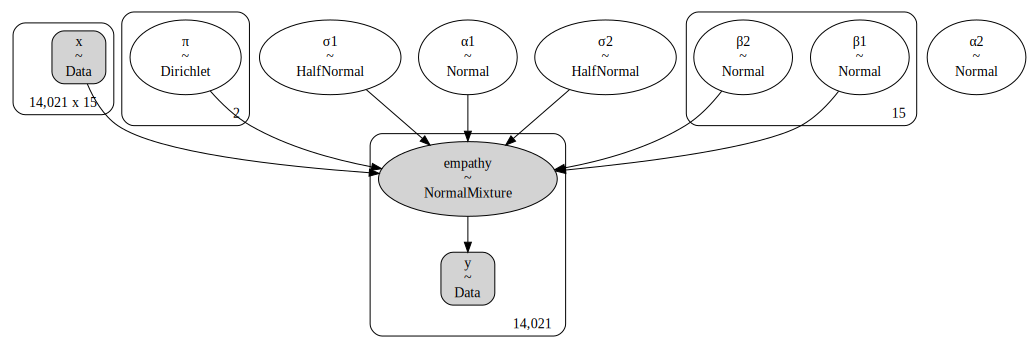

In [ ]:
pm.model_graph.model_to_graphviz(free_fix_empathy)

In [ ]:
az.summary(free_fix_empathy_trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α1,87.36,2.34,85.45,91.47,1.16,0.89,7.10,26.74,1.53
β1[0],2.65,7.64,-11.17,17.34,1.04,0.74,54.01,461.88,1.05
β1[1],5.66,5.52,-1.63,12.71,2.71,2.07,5.38,29.08,2.00
β1[2],5.50,7.27,-5.78,20.12,1.89,1.36,15.50,384.86,1.17
β1[3],-0.81,6.62,-13.11,12.15,2.00,1.45,11.04,53.04,1.26
β1[4],2.31,2.61,-1.77,7.23,1.05,0.78,6.78,27.98,1.57
β1[5],-3.25,5.30,-12.67,5.44,1.67,1.22,10.31,180.69,1.29
β1[6],1.20,4.12,-5.08,8.53,1.49,1.09,8.03,85.01,1.42
β1[7],-0.38,0.58,-1.53,0.79,0.18,0.13,10.96,32.00,1.27
β1[8],-1.79,2.61,-6.98,3.01,0.69,0.49,15.79,57.30,1.17


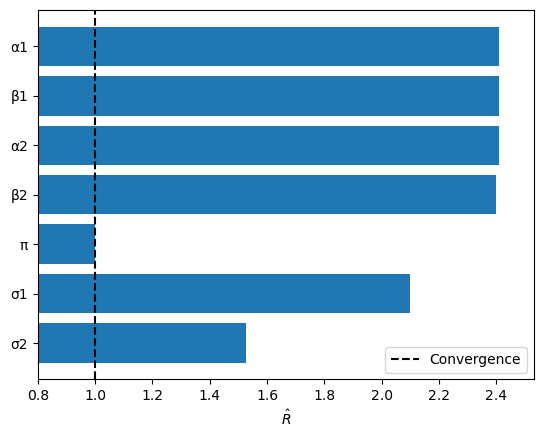

In [ ]:
fig, ax = plt.subplots()

max_rhat = (az.rhat(free_fix_empathy_trace)
               .max()
               .to_array())
nvar, = max_rhat.shape

ax.barh(np.arange(nvar), max_rhat);
ax.axvline(1, c='k', ls='--', label="Convergence");

ax.set_xlim(left=0.8);
ax.set_xlabel(r"$\hat{R}$");

ax.set_yticks(np.arange(nvar));
ax.set_yticklabels(max_rhat.coords["variable"].to_numpy()[::-1]);

ax.legend();

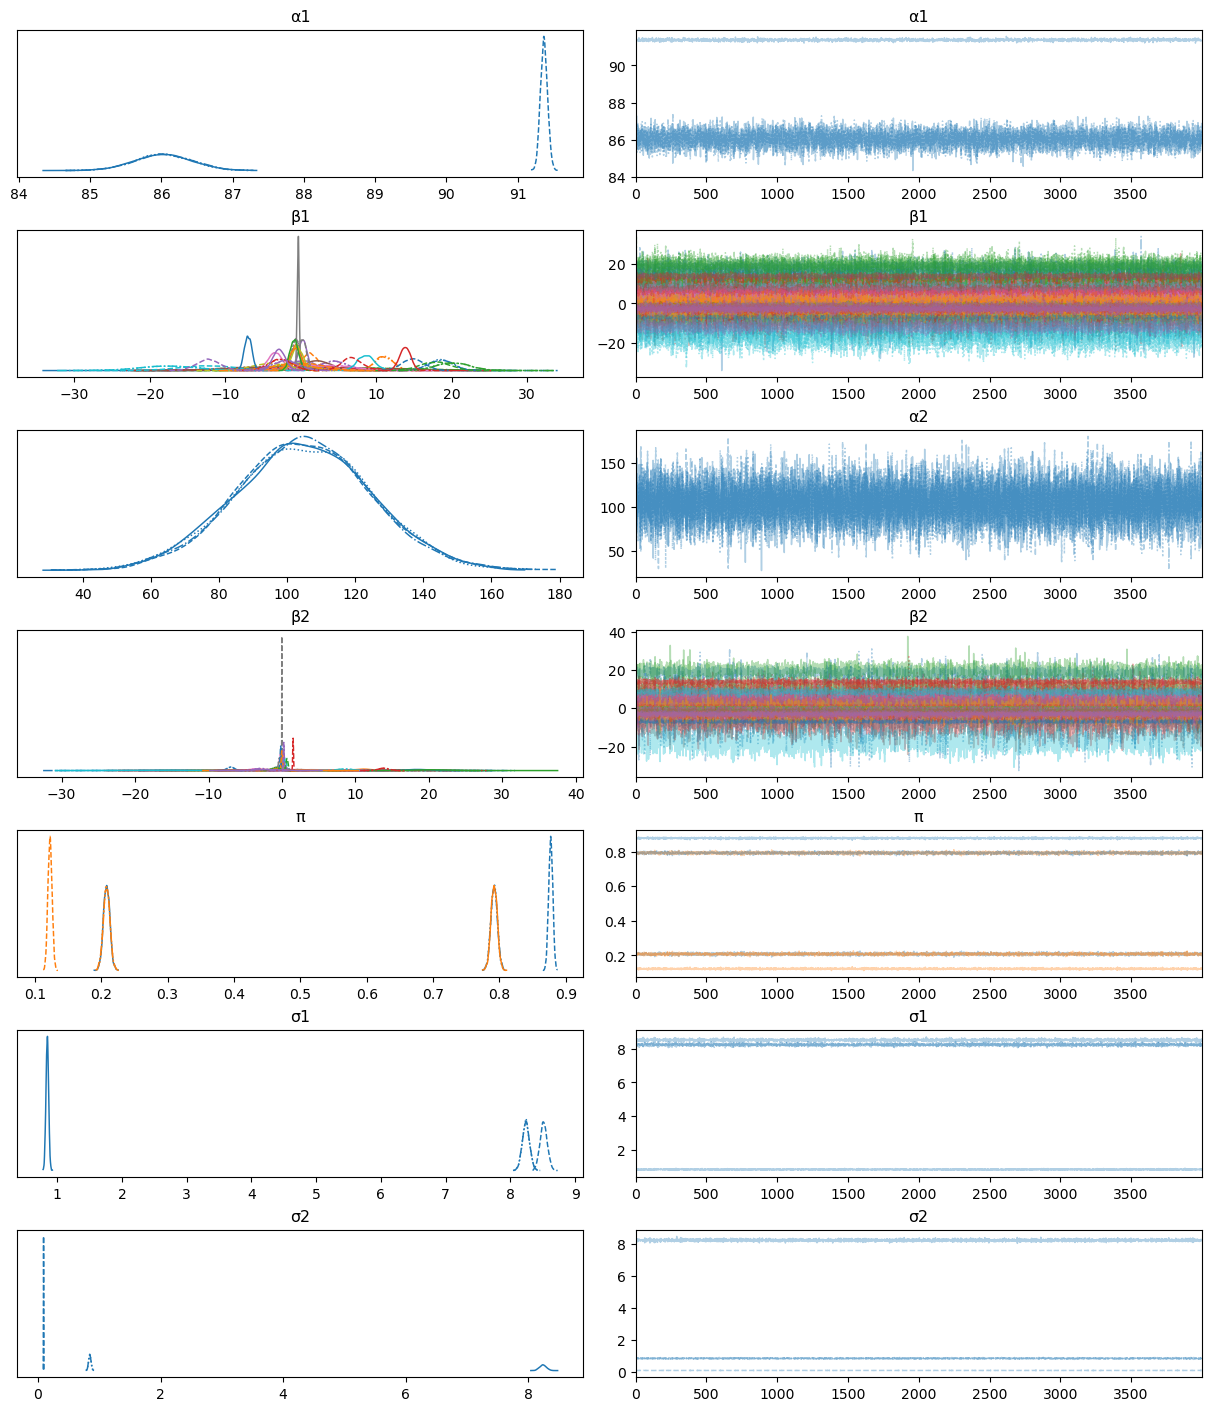

In [ ]:
trace = az.plot_trace(free_fix_empathy_trace)

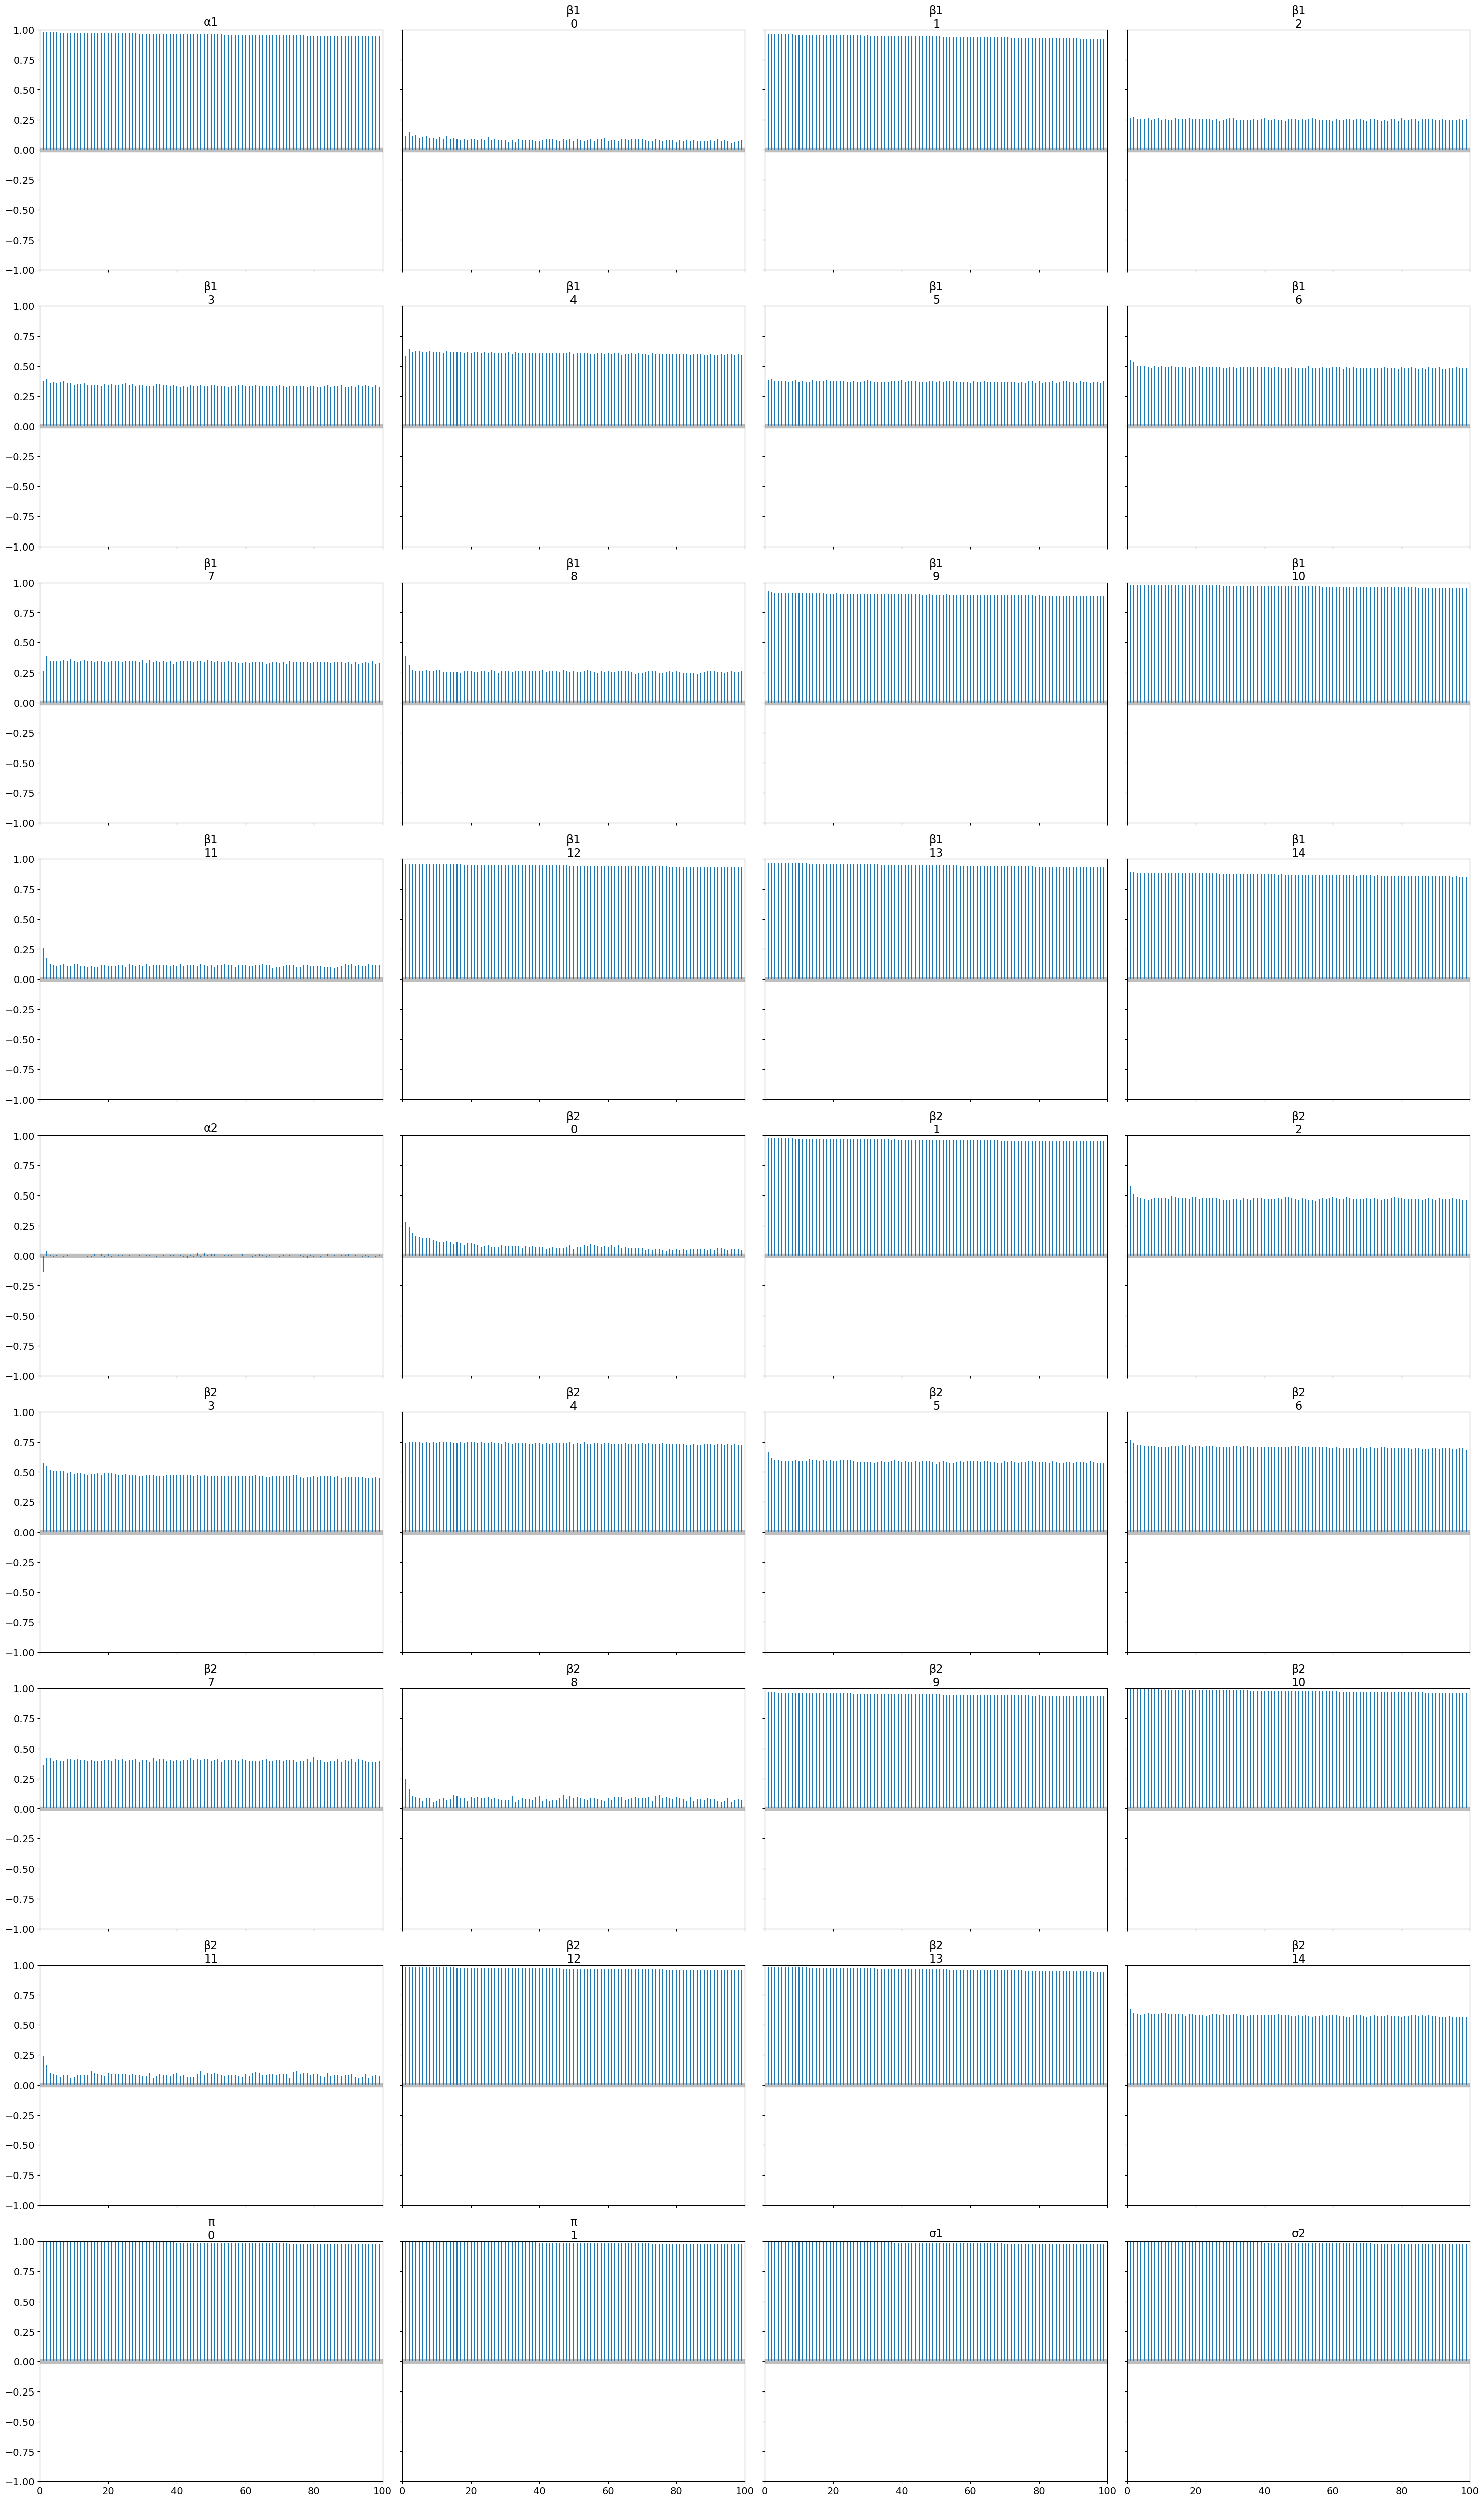

In [ ]:
az.plot_autocorr(free_fix_empathy_trace, combined=True);

In [ ]:
with free_fix_empathy:
    fix_free_ppc = pm.sample_posterior_predictive(free_fix_empathy_trace)
    fix_free_ppc_data = az.from_pymc3(model=free_fix_empathy, posterior_predictive=fix_free_ppc) 

In [ ]:
fix_free_sampled_labels = fix_free_ppc_data.posterior_predictive['empathy'].to_numpy().mean(axis=(0,1))

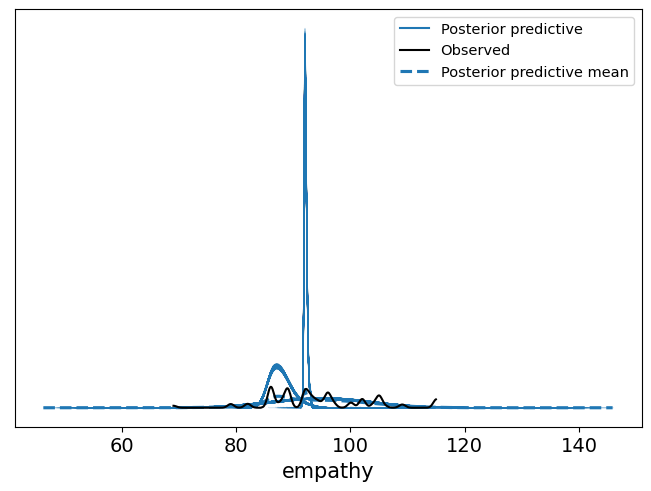

In [ ]:
az.plot_ppc(fix_free_ppc_data);

In [ ]:
mean_squared_error(free_fix_labels_train, fix_free_sampled_labels, squared= False)

8.020259789513311